# Human PBMCs from 10X data 

Here we analyse 

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
#from gprofiler import GProfiler

#import sys

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.4+6.ge614f59 anndata==0.6.22.post1 umap==0.3.9 numpy==1.15.4 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
# install some R packages through rpy2 (the rest are installed via conda)
packnames = ('RColorBrewer', 'gam', 'ggplot2', 'plyr')
from rpy2.robjects.vectors import StrVector
#utils.install_packages(StrVector(packnames))
results_file = './write/pbmc10x.h5ad'  # the file that will store the analysis results

In [4]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
#library(slingshot)
#library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

R[write to console]: Loading required package: BiocParallel

R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans

In [5]:
## Load previously processed dataset
adata = sc.read_h5ad(results_file)

In [6]:
# Set up data loading
file_base = '../../Munich/datasets/human/10xPBMC/filtered_feature_bc_matrix/'
adata = sc.read_10x_mtx(path=file_base, var_names='gene_symbols', make_unique=True, cache=True, gex_only=True )

... writing an h5ad cache file to speedup reading next time


In [6]:
adata

AnnData object with n_obs × n_vars = 10642 × 15818 
    obs: 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'size_factors', 'louvain_r1', 'louvain_r0.5'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'diffmap_evals', 'draw_graph', 'louvain', 'louvain_r0.5_colors', 'louvain_r1_colors', 'neighbors', 'pca', 'rank_genes_r0.5'
    obsm: 'X_diffmap', 'X_draw_graph_fr', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

In [9]:
adata.var.head()

,gene_ids,feature_types
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
AL627309.1,ENSG00000238009,Gene Expression
AL627309.3,ENSG00000239945,Gene Expression


In [10]:
adata.X[1:5,1:5]
adata.X = adata.X.toarray()

In [11]:
adata.var_names_make_unique()

In [12]:
# Checking the total size of the data set
adata.shape

(11769, 33538)

# Pre-processing and visualization

## Quality control

In [13]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

In [14]:
mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']


... storing 'feature_types' as categorical


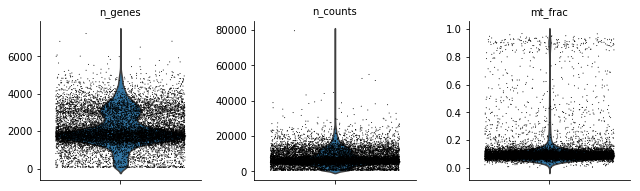

In [15]:
# Quality control - plot QC metrics
sc.pl.violin(adata, ['n_genes', 'n_counts', 'mt_frac'],
             jitter=0.4, multi_panel=True)

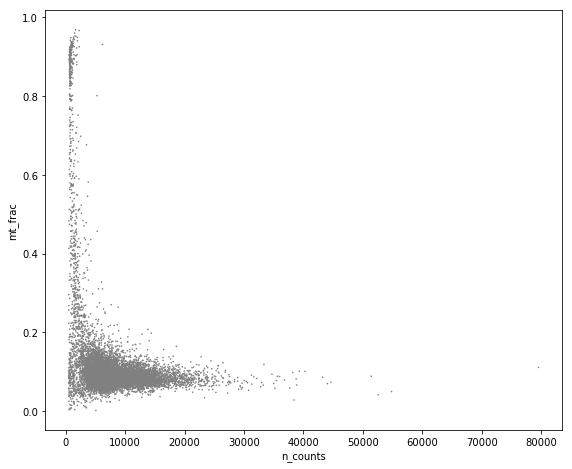

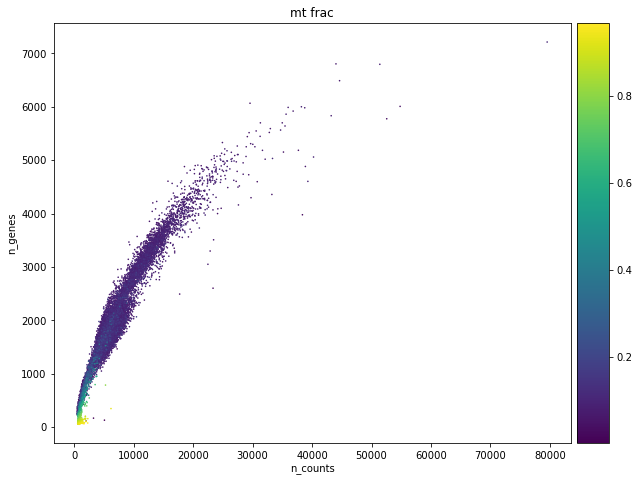

In [127]:
sc.pl.scatter(adata, x='n_counts', y='mt_frac')
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')

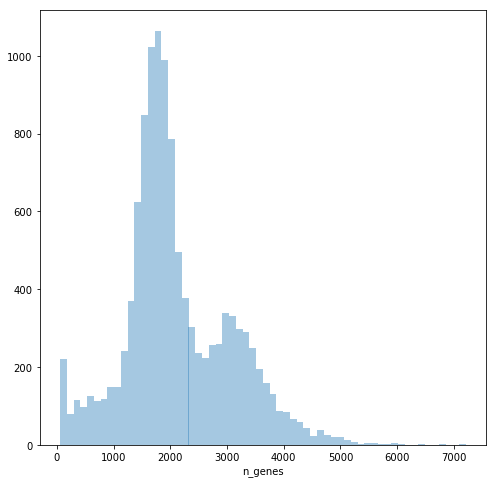

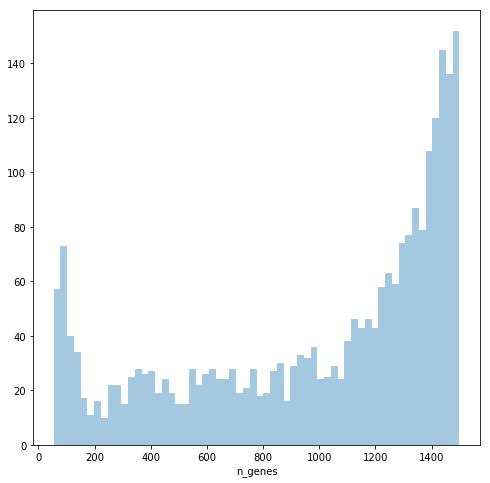

In [128]:
#Thresholding decision: genes
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1500], kde=False, bins=60)
plt.show()



In [16]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 40000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 1000)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 11769
filtered out 8 cells that havemore than 40000 counts
Number of cells after max count filter: 11761
Number of cells after MT filter: 11039
filtered out 397 cells that haveless than 1000 genes expressed


Trying to set attribute `.obs` of view, making a copy.


Number of cells after gene filter: 10642


In [17]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 33538
filtered out 17720 genes that are detectedin less than 20 cells
Number of genes after cell filter: 15818


## Normalization

In [18]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 15
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished (0:00:06)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01)


In [19]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [20]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [21]:
#Delete adata_pp
del adata_pp

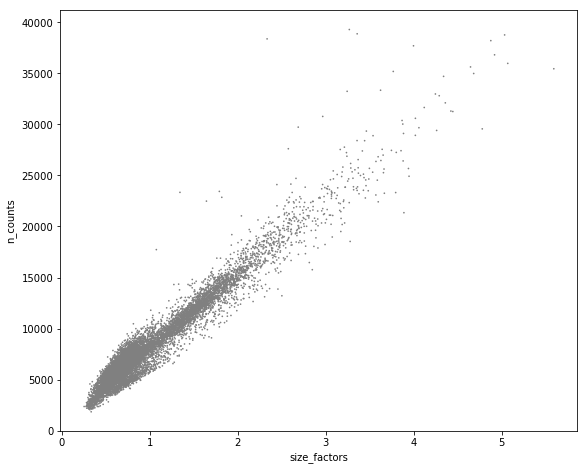

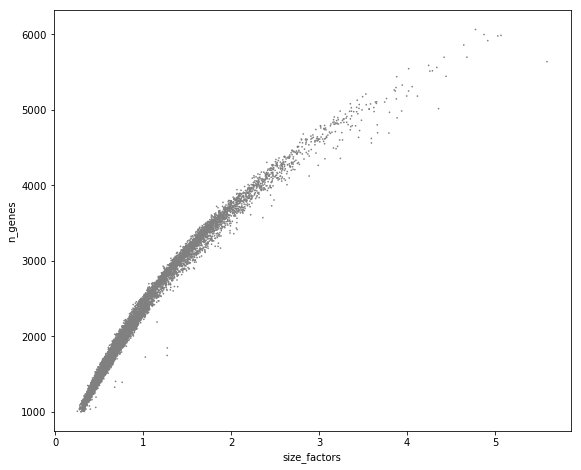

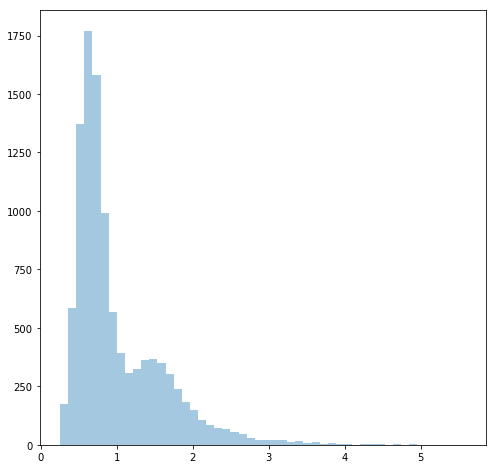

In [22]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [23]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [24]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [25]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

## Highly variable genes

In [26]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 4000


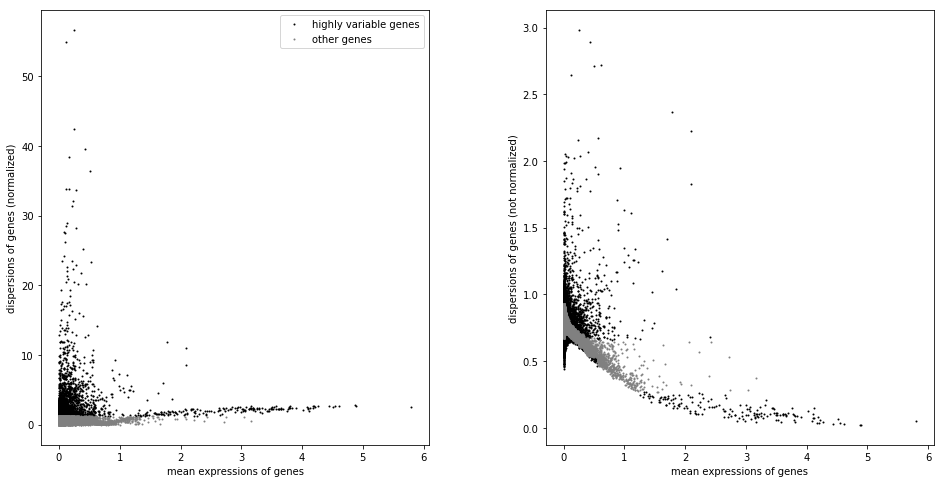

In [27]:
sc.pl.highly_variable_genes(adata)

## Visualization

In [28]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.tsne(adata, n_jobs=12) #Note n_jobs works for MulticoreTSNE, but not regular implementation)
sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:03)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished (0:01:44)
computing UMAP


/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


    finished (0:00:11)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99995667 0.9999328  0.99957114 0.9982501  0.99693793
     0.992102   0.9890037  0.98870015 0.98508966 0.98399556 0.9833606
     0.97902733 0.9783206  0.9734243 ]
    finished (0:00:00)
drawing single-cell graph using layout 'fa'
    finished (0:06:57)


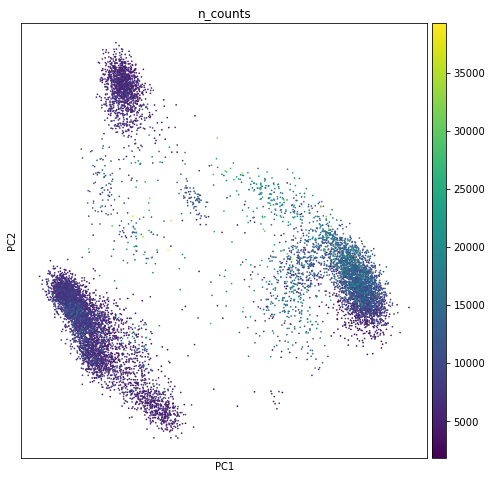

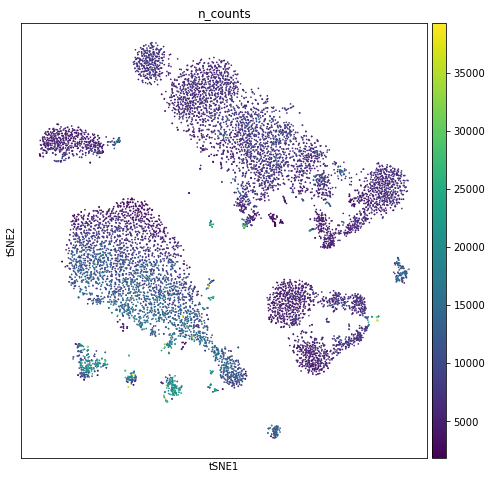

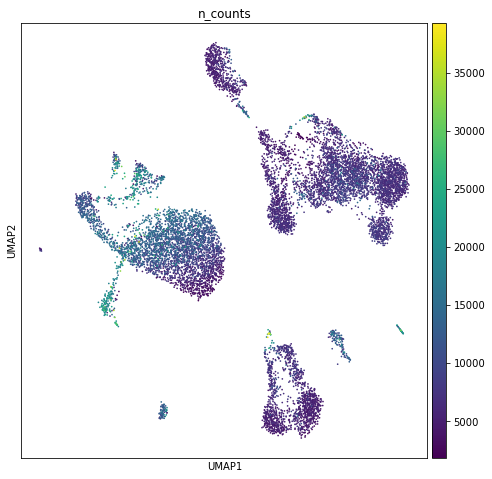

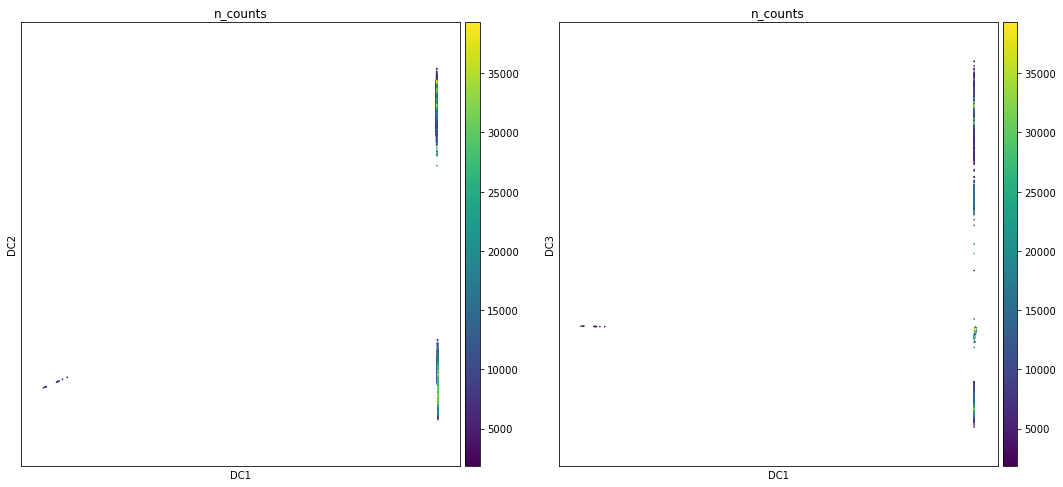

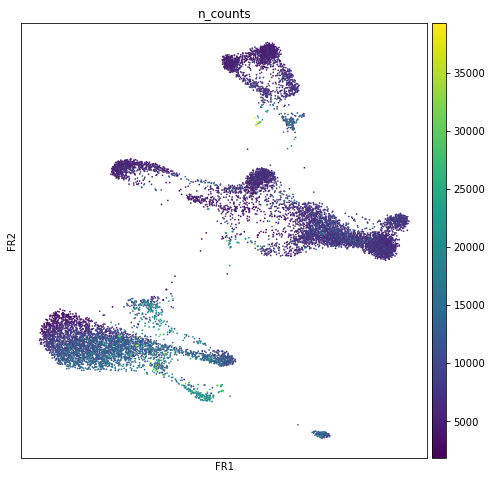

In [29]:
sc.pl.pca_scatter(adata, color='n_counts')
sc.pl.tsne(adata, color='n_counts')
sc.pl.umap(adata, color='n_counts')
sc.pl.diffmap(adata, color='n_counts', components=['1,2','1,3'])
sc.pl.draw_graph(adata, color='n_counts')

In [30]:
adata.write(results_file)

## Clustering

In [31]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5', random_state=10)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


In [32]:
adata.obs['louvain_r0.5'].value_counts()

0     3077
1     1931
2     1480
3     1422
4     1051
5      597
6      360
7      313
8      154
9      116
10      81
11      32
12      28
Name: louvain_r0.5, dtype: int64

In [33]:
adata.obs['louvain_r1'].value_counts()

0     1913
1     1659
2     1151
3     1062
4      657
5      587
6      569
7      550
8      523
9      366
10     345
11     285
12     246
13     242
14     154
15     117
16      81
17      72
18      35
19      28
Name: louvain_r1, dtype: int64

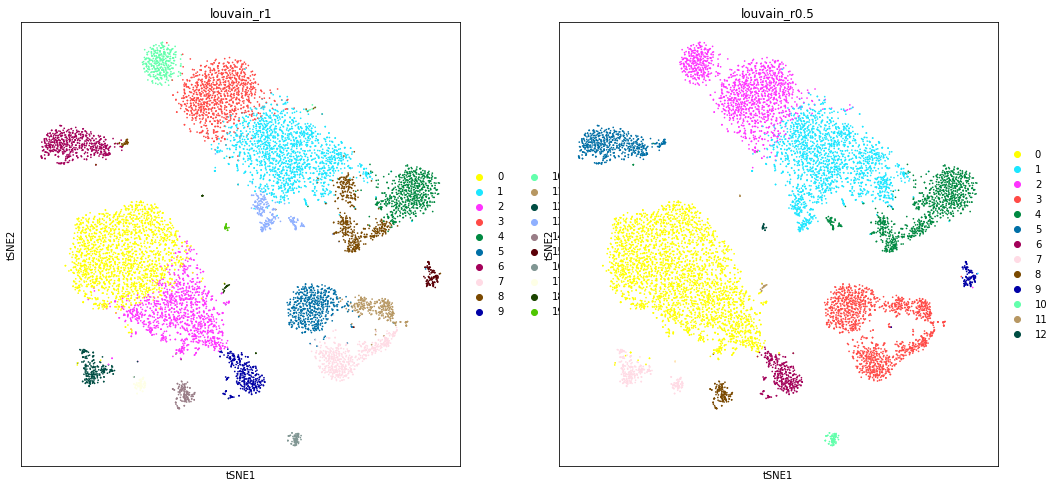

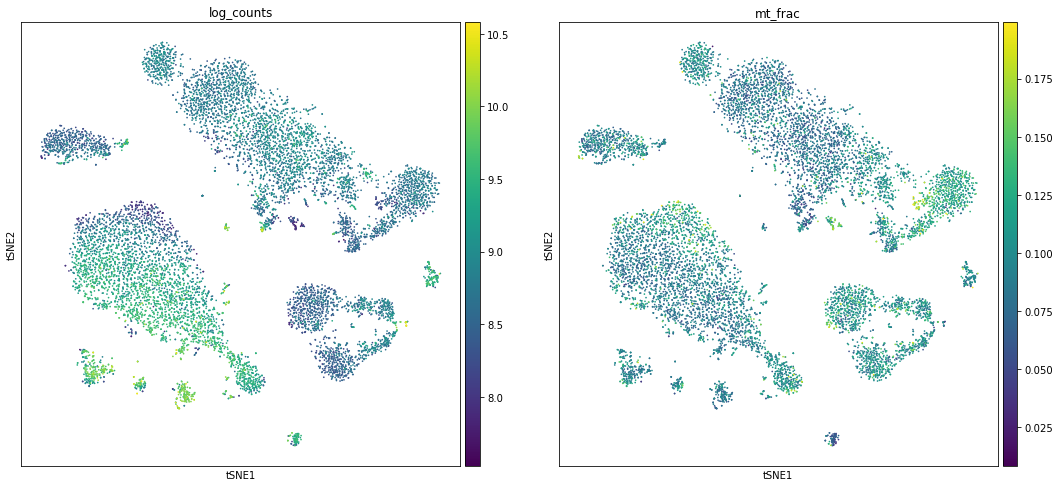

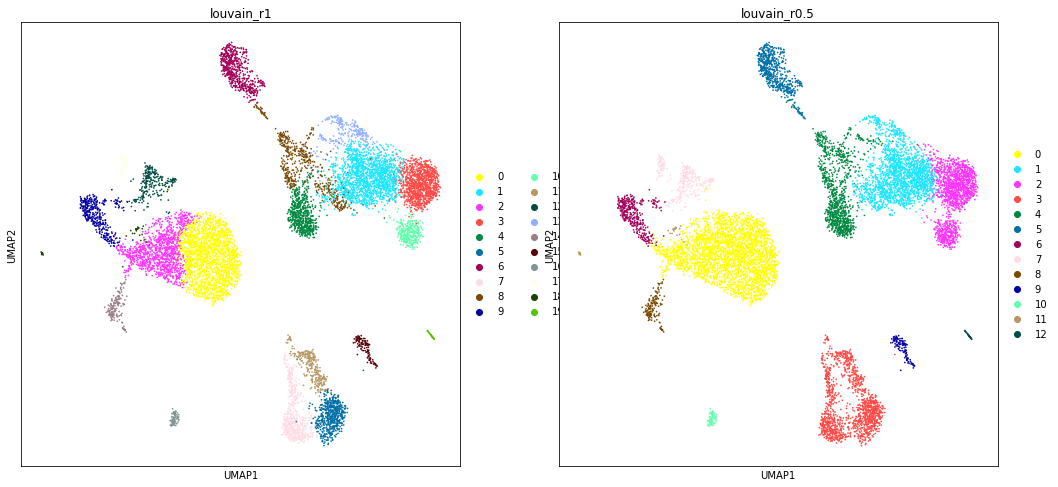

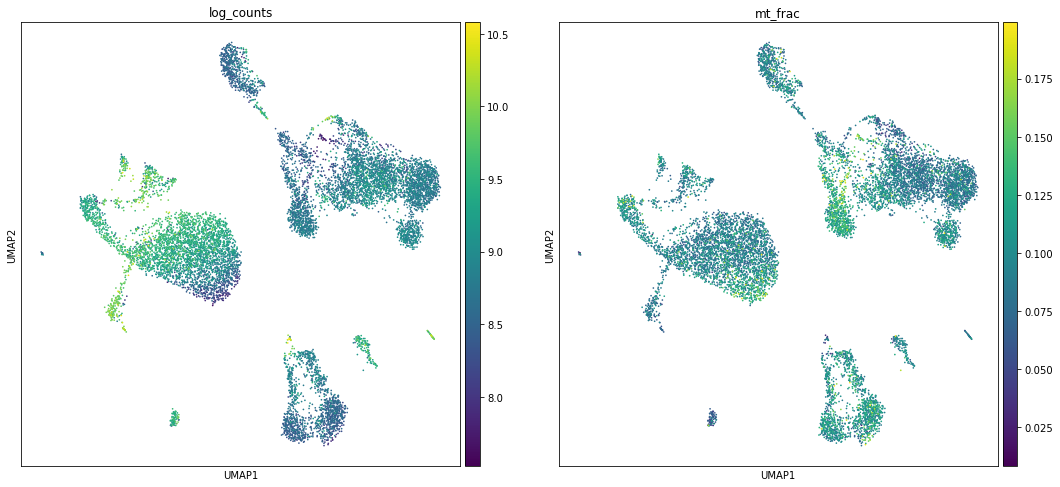

In [35]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.tsne(adata, color=['louvain_r1', 'louvain_r0.5'], palette=sc.pl.palettes.default_64)
sc.pl.tsne(adata, color=['log_counts', 'mt_frac'])
sc.pl.umap(adata, color=['louvain_r1', 'louvain_r0.5'], palette=sc.pl.palettes.default_64)
sc.pl.umap(adata, color=['log_counts', 'mt_frac'])



## Marker genes and cluster annotation

In [36]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r0.5', key_added='rank_genes_r0.5')

ranking genes
    finished (0:00:14)


In [7]:
# Known marker genes taken from PanglaoDB
markers_short_df = pd.read_csv('../../Munich/Immune_markers_short_12.txt', delimiter='\t')
markers_short_df.shape

(975, 14)

In [8]:
markers_short_df.head()

,species,official.gene.symbol,cell.type,nicknames,ubiquitousness.index,product.description,gene.type,canonical.marker,germ.layer,organ,sensitivity_human,sensitivity_mouse,specificity_human,specificity_mouse
417,Mm Hs,CD2,B cells,NaN,0.040,CD2 molecule,protein-coding gene,NaN,Mesoderm,Immune system,0.000000,0.212355,0.095847,0.026556
418,Mm Hs,CD5,B cells,NaN,0.004,CD5 molecule,protein-coding gene,1.0,Mesoderm,Immune system,0.000000,0.000000,0.004153,0.004502
419,Mm Hs,MS4A1,B cells,Bp35|MS4A2|CD20,0.014,membrane spanning 4-domains A1,protein-coding gene,1.0,Mesoderm,Immune system,0.483871,0.617761,0.011182,0.001566
420,Mm Hs,CR2,B cells,CD21|C3DR,0.001,complement C3d receptor 2,protein-coding gene,1.0,Mesoderm,Immune system,0.048387,0.034749,0.000000,0.000000
421,Mm Hs,CD22,B cells,SIGLEC-2|SIGLEC2,0.003,CD22 molecule,protein-coding gene,1.0,Mesoderm,Immune system,0.096774,0.127413,0.001278,0.000196


In [9]:
markers_short_df_hum = markers_short_df[(markers_short_df['species'] == 'Hs') | (markers_short_df['species'] == 'Mm Hs')]
markers_short_df_hum.shape

(892, 14)

In [10]:
cell_types = list(markers_short_df_hum['cell.type'].unique())

In [11]:
markers_dict = {}
type(markers_dict)

dict

In [12]:
for ctype in cell_types:
    df = markers_short_df_hum[markers_short_df_hum['cell.type'] == ctype]
    markers_dict[ctype] = df['official.gene.symbol'].to_list()

In [43]:
markers_dict

{'B cells': ['CD2',
  'CD5',
  'MS4A1',
  'CR2',
  'CD22',
  'FCER2',
  'CD40',
  'CD69',
  'CD70',
  'CD79A',
  'CD79B',
  'CD80',
  'CD86',
  'TNFRSF9',
  'SDC1',
  'TNFSF4',
  'TNFRSF13B',
  'TNFRSF13C',
  'PDCD1',
  'IGHD',
  'IGHM',
  'RASGRP3',
  'HLA-DRA',
  'LTB',
  'HLA-DQA1',
  'FLI1',
  'CD14',
  'SEMA6D',
  'LAIR1',
  'IFIT3',
  'IGLL1',
  'DNTT',
  'MME',
  'SPN',
  'CD19',
  'CD24',
  'CD27',
  'B3GAT1',
  'CD72',
  'MUM1',
  'PAX5',
  'JCHAIN',
  'MZB1',
  'LY6D',
  'FCMR',
  'BANK1',
  'EDEM1',
  'VPREB3',
  'POU2AF1',
  'CRELD2',
  'DERL3',
  'RALGPS2',
  'FCHSD2',
  'POLD4',
  'TNFRSF17',
  'HVCN1',
  'FCRLA',
  'EDEM2',
  'BLNK',
  'TXNDC11',
  'BTLA',
  'SMAP2',
  'FKBP11',
  'SEC61A1',
  'SPCS3',
  'SPIB',
  'EAF2',
  'CXCR4',
  'BIRC3',
  'IGLC2',
  'IGLC3',
  'IGLC1',
  'IL21R',
  'IGKC',
  'VPREB1',
  'LRMP',
  'KLHL6',
  'SLAMF6',
  'FAM129C',
  'BST1',
  'MSH5',
  'DOK3',
  'BACH2',
  'PXK',
  'IGHG1',
  'IGHG3',
  'IGHG4',
  'CD38',
  'PTPRC',
  'EBF1',
  'BC

In [13]:
cell_annotation = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r0.5')
cell_annotation
    

,0,1,2,3,4,5,6,7,8,9,10,11,12
B cells,1.0,3.0,2.0,34.0,3.0,0.0,1.0,2.0,4.0,36.0,8.0,0.0,1.0
B cells naive,0.0,2.0,0.0,32.0,2.0,0.0,0.0,0.0,4.0,32.0,3.0,0.0,0.0
Dendritic cells,15.0,0.0,1.0,12.0,5.0,6.0,12.0,15.0,16.0,9.0,5.0,0.0,3.0
Erythroid-like and erythroid precursor cells,3.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0
Gamma delta T cells,0.0,0.0,0.0,0.0,12.0,18.0,0.0,0.0,1.0,0.0,3.0,1.0,1.0
Monocytes,13.0,0.0,0.0,2.0,1.0,3.0,8.0,13.0,3.0,2.0,1.0,0.0,0.0
NK cells,1.0,5.0,2.0,0.0,22.0,28.0,3.0,2.0,2.0,1.0,1.0,2.0,0.0
Plasmacytoid dendritic cells,2.0,1.0,1.0,7.0,2.0,2.0,0.0,2.0,0.0,6.0,21.0,1.0,2.0
Platelets,4.0,1.0,0.0,2.0,3.0,6.0,2.0,4.0,1.0,3.0,4.0,33.0,1.0
T cells,1.0,15.0,7.0,2.0,27.0,17.0,1.0,1.0,0.0,3.0,1.0,1.0,2.0


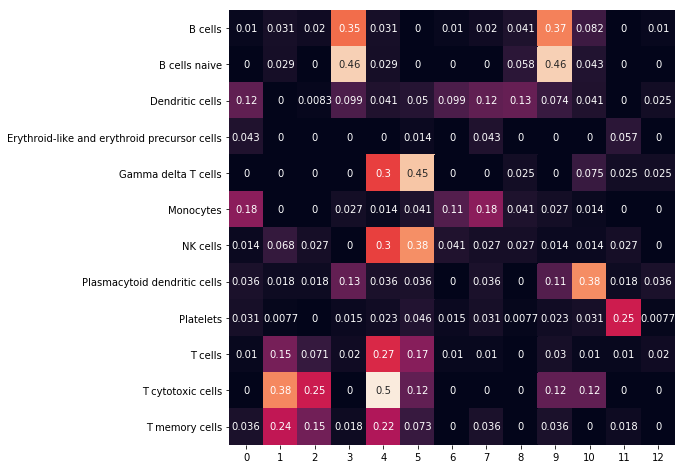

In [14]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r0.5', normalize='reference')
sb.heatmap(cell_annotation_norm, cbar=False, annot=True)

In [16]:
markers_long_df = pd.read_csv('../../Munich/Immune_markers_long_29.txt', delimiter='\t')
markers_long_df_hum = markers_long_df[(markers_long_df['species'] == 'Hs') | (markers_long_df['species'] == 'Mm Hs')]
markers_long_df_hum.shape

(1712, 14)

In [17]:
cell_types = list(markers_long_df_hum['cell.type'].unique())
cell_types

['B cells',
 'B cells memory',
 'B cells naive',
 'Basophils',
 'Dendritic cells',
 'Eosinophils',
 'Erythroblasts',
 'Erythroid-like and erythroid precursor cells',
 'Gamma delta T cells',
 'Macrophages',
 'Mast cells',
 'Megakaryocytes',
 'Monocytes',
 'Myeloid-derived suppressor cells',
 'Natural killer T cells',
 'Neutrophils',
 'NK cells',
 'Nuocytes',
 'Plasma cells',
 'Plasmacytoid dendritic cells',
 'Platelets',
 'Red pulp macrophages',
 'Reticulocytes',
 'T cells',
 'T cytotoxic cells',
 'T follicular helper cells',
 'T helper cells',
 'T memory cells',
 'T regulatory cells']

In [19]:
markers_dict_long = {}
for ctype in cell_types:
    df = markers_long_df_hum[markers_long_df_hum['cell.type'] == ctype]
    markers_dict_long[ctype] = df['official.gene.symbol'].to_list()

In [20]:
cell_annotation_long = sc.tl.marker_gene_overlap(adata, markers_dict_long, key='rank_genes_r0.5')

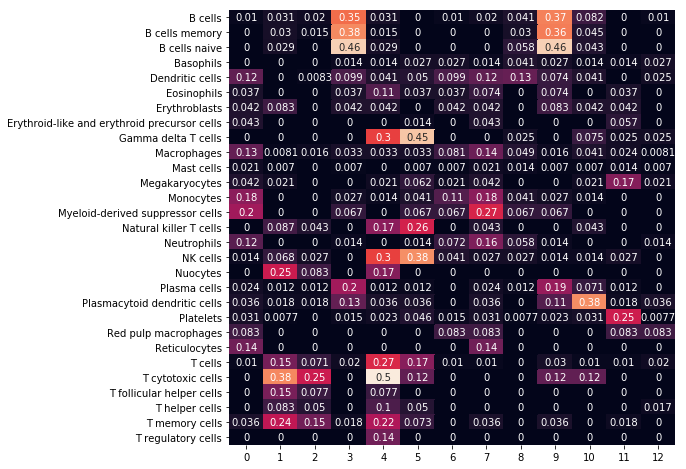

In [21]:
cell_annotation_long_norm = sc.tl.marker_gene_overlap(adata, markers_dict_long, key='rank_genes_r0.5', normalize='reference')
sb.heatmap(cell_annotation_long_norm, cbar=False, annot=True)

In [24]:
#Calculate marker genes r1
sc.tl.rank_genes_groups(adata, groupby='louvain_r1', key_added='rank_genes_r1')
cell_annotation_long_r1 = sc.tl.marker_gene_overlap(adata, markers_dict_long, key='rank_genes_r1')

ranking genes
    finished (0:00:20)


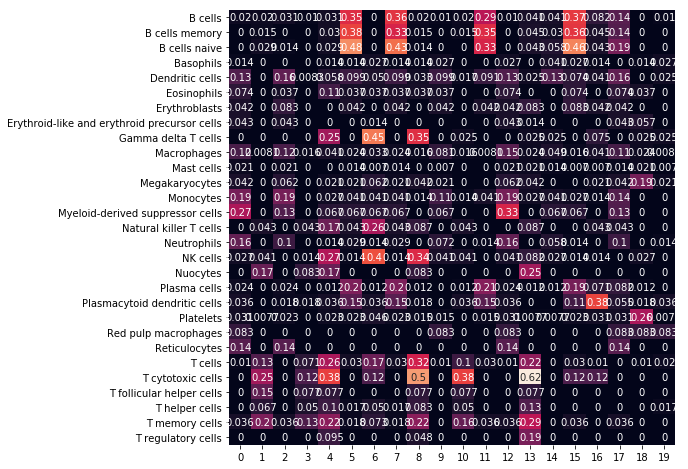

In [25]:
cell_annotation_long_norm_r1 = sc.tl.marker_gene_overlap(adata, markers_dict_long, key='rank_genes_r1', normalize='reference')
sb.heatmap(cell_annotation_long_norm_r1, cbar=False, annot=True)

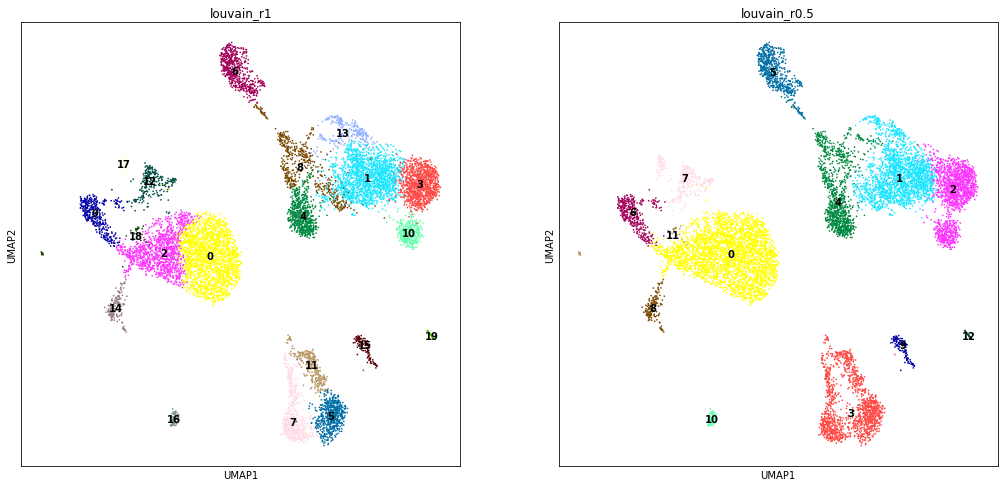

In [26]:
sc.pl.umap(adata, color=['louvain_r1', 'louvain_r0.5'], palette=sc.pl.palettes.default_64, legend_loc='on data')

In [48]:
adata.write(results_file)